C:\Users\dh43a\anaconda3\lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


Generating GIF... This may take a moment.
Successfully saved to epitaxy_simulation.gif


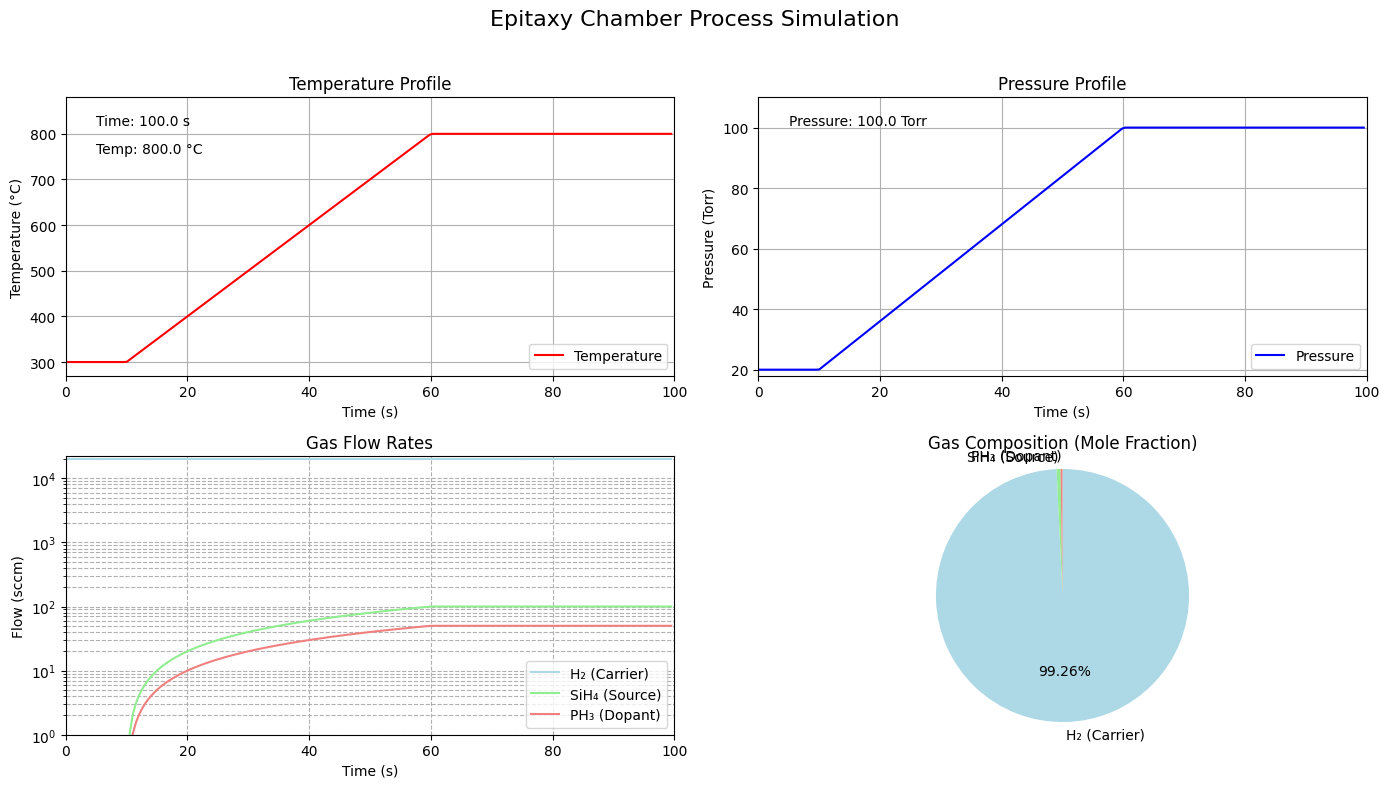

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- 1. 시뮬레이션 공정 레시피 설정 ---
# (이 부분은 이전 코드와 동일합니다)
GAS_PROPERTIES = {
    'H2': {'color': 'lightblue', 'label': 'H₂ (Carrier)'},
    'SiH4': {'color': 'lightgreen', 'label': 'SiH₄ (Source)'},
    'PH3': {'color': 'lightcoral', 'label': 'PH₃ (Dopant)'}
}
gases = list(GAS_PROPERTIES.keys())

TOTAL_TIME = 100
FRAMES = 200
t_array = np.linspace(0, TOTAL_TIME, FRAMES)
T_PURGE_END = 10
T_RAMP_END = 60

# --- 2. 시간에 따른 공정 변수(온도, 압력, 유량) 계산 ---
# (이 부분은 이전 코드와 동일합니다)
temp = np.zeros(FRAMES)
pressure = np.zeros(FRAMES)
flows = {gas: np.zeros(FRAMES) for gas in gases}

temp_start, temp_process = 300, 800
pressure_start, pressure_process = 20, 100
flow_h2_process = 20000
flow_sih4_process = 100
flow_ph3_process = 50

for i, t in enumerate(t_array):
    if t <= T_PURGE_END:
        progress = 0
        ramp_up = False
    elif t <= T_RAMP_END:
        progress = (t - T_PURGE_END) / (T_RAMP_END - T_PURGE_END)
        ramp_up = True
    else:
        progress = 1
        ramp_up = False
        
    temp[i] = temp_start + (temp_process - temp_start) * progress
    pressure[i] = pressure_start + (pressure_process - pressure_start) * progress
    flows['H2'][i] = flow_h2_process
    flows['SiH4'][i] = flow_sih4_process * progress
    flows['PH3'][i] = flow_ph3_process * progress


# --- 3. 파생 데이터 계산 (총 유량, 몰 분율, 분압) ---
# (이 부분은 이전 코드와 동일합니다)
total_flow = sum(flows.values())
total_flow[total_flow == 0] = 1 
mole_fractions = {gas: flows[gas] / total_flow for gas in gases}
partial_pressures = {gas: mole_fractions[gas] * pressure for gas in gases}

# --- 4. Matplotlib 애니메이션 설정 ---
# (이 부분은 이전 코드와 동일합니다)
fig = plt.figure(figsize=(14, 8))
fig.suptitle('Epitaxy Chamber Process Simulation', fontsize=16)

gs = fig.add_gridspec(2, 2)
ax_temp = fig.add_subplot(gs[0, 0])
ax_pres = fig.add_subplot(gs[0, 1])
ax_flow = fig.add_subplot(gs[1, 0])
ax_pie = fig.add_subplot(gs[1, 1])

line_temp, = ax_temp.plot([], [], 'r-', label='Temperature')
line_pres, = ax_pres.plot([], [], 'b-', label='Pressure')
lines_flow = {gas: ax_flow.plot([], [], '-', color=prop['color'], label=prop['label'])[0] for gas, prop in GAS_PROPERTIES.items()}

time_text = ax_temp.text(0.05, 0.9, '', transform=ax_temp.transAxes)
pres_text = ax_pres.text(0.05, 0.9, '', transform=ax_pres.transAxes)
temp_text = ax_temp.text(0.05, 0.8, '', transform=ax_temp.transAxes)

def init():
    ax_temp.set_xlim(0, TOTAL_TIME)
    ax_temp.set_ylim(temp_start * 0.9, temp_process * 1.1)
    ax_temp.set_title('Temperature Profile')
    ax_temp.set_xlabel('Time (s)')
    ax_temp.set_ylabel('Temperature (°C)')
    ax_temp.grid(True)
    ax_temp.legend(loc='lower right')

    ax_pres.set_xlim(0, TOTAL_TIME)
    ax_pres.set_ylim(pressure_start * 0.9, pressure_process * 1.1)
    ax_pres.set_title('Pressure Profile')
    ax_pres.set_xlabel('Time (s)')
    ax_pres.set_ylabel('Pressure (Torr)')
    ax_pres.grid(True)
    ax_pres.legend(loc='lower right')
    
    ax_flow.set_xlim(0, TOTAL_TIME)
    ax_flow.set_ylim(1, flow_h2_process * 1.1) # Y축 최소값을 1로 설정하여 log scale 오류 방지
    ax_flow.set_title('Gas Flow Rates')
    ax_flow.set_xlabel('Time (s)')
    ax_flow.set_ylabel('Flow (sccm)')
    ax_flow.set_yscale('log')
    ax_flow.legend(loc='lower right')
    ax_flow.grid(True, which="both", ls="--")
    
    ax_pie.set_title('Gas Composition (Mole Fraction)')
    ax_pie.axis('equal')

    return [line_temp, line_pres, *lines_flow.values(), time_text, pres_text, temp_text]

def update(frame):
    line_temp.set_data(t_array[:frame], temp[:frame])
    line_pres.set_data(t_array[:frame], pressure[:frame])
    for gas in gases:
        # 0인 값은 로그 스케일에서 그리지 않도록 처리
        valid_indices = flows[gas][:frame] > 0
        lines_flow[gas].set_data(t_array[:frame][valid_indices], flows[gas][:frame][valid_indices])

    time_text.set_text(f'Time: {t_array[frame]:.1f} s')
    temp_text.set_text(f'Temp: {temp[frame]:.1f} °C')
    pres_text.set_text(f'Pressure: {pressure[frame]:.1f} Torr')

    ax_pie.clear()
    ax_pie.set_title('Gas Composition (Mole Fraction)')
    
    current_fractions = [mole_fractions[gas][frame] for gas in gases]
    valid_fractions = [f for f in current_fractions if f > 1e-6]
    valid_labels = [GAS_PROPERTIES[g]['label'] for g, f in zip(gases, current_fractions) if f > 1e-6]
    valid_colors = [GAS_PROPERTIES[g]['color'] for g, f in zip(gases, current_fractions) if f > 1e-6]

    if valid_fractions:
        ax_pie.pie(valid_fractions, labels=valid_labels, colors=valid_colors,
                   autopct=lambda p: f'{p:.2f}%' if p > 1 else '',
                   startangle=90, counterclock=False)
    
    ax_pie.axis('equal')
    
    return [line_temp, line_pres, *lines_flow.values(), time_text, pres_text, temp_text, ax_pie]

# --- 5. 애니메이션 생성 및 GIF로 저장 ---
ani = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False, interval=50)

# GIF 파일로 저장
print("Generating GIF... This may take a moment.")
try:
    # writer='imagemagick'을 명시적으로 지정
    ani.save('epitaxy_simulation.gif', writer='imagemagick', fps=20)
    print("Successfully saved to epitaxy_simulation.gif")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("ImageMagick not found. Please ensure it is installed and in your system's PATH.")
    print("Installation instructions can be found at: https://imagemagick.org/script/download.php")

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show() # GIF 저장 시에는 화면에 표시하지 않음

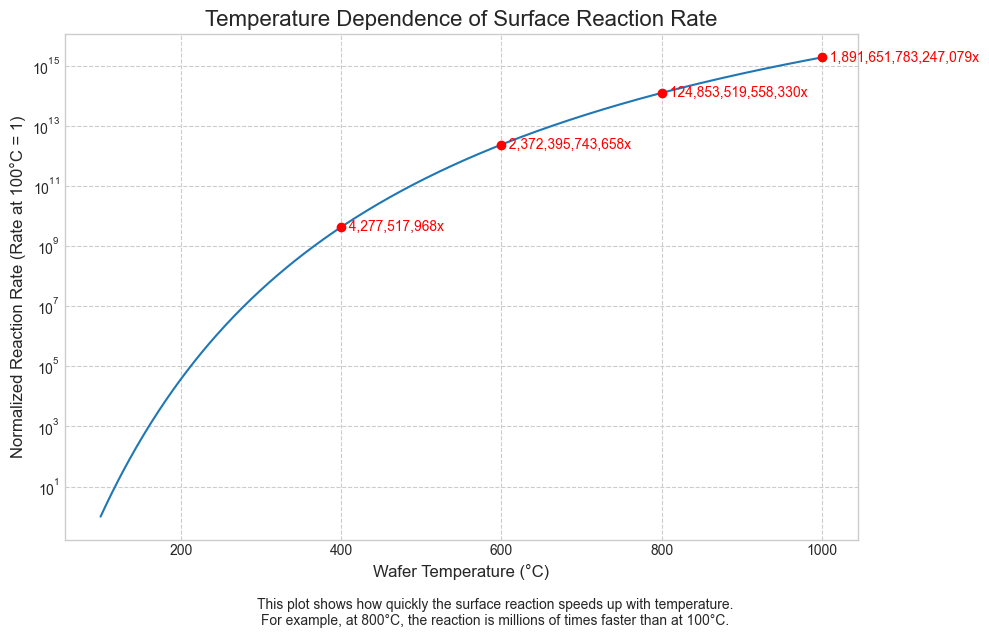

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 상수 정의 ---
R = 8.314  # 기체 상수 (J/(mol·K))

# 활성화 에너지 (Activation Energy, Ea) 설정
# 예시: 실리콘(Si) 성장에서 SiH4 가스의 분해 반응 활성화 에너지
# 실제 값은 공정마다 다르지만, 일반적인 CVD 값(약 1.6 eV)을 사용
# 1 eV = 96485 J/mol
Ea = 1.6 * 96485  # J/mol 단위

# 전지수 인자 (A)
# 상대적인 비율을 계산할 것이므로, A는 1로 설정해도 무방합니다.
A = 1.0

# --- 2. 아레니우스 방정식 함수 정의 ---
def calculate_reaction_rate(T_celsius, Ea, A):
    """
    섭씨 온도를 입력받아 아레니우스 방정식에 따른 반응 속도 상수를 반환합니다.
    """
    # 섭씨(Celsius)를 절대온도(Kelvin)로 변환
    T_kelvin = T_celsius + 273.15
    
    # k = A * exp(-Ea / (R * T))
    rate_constant = A * np.exp(-Ea / (R * T_kelvin))
    return rate_constant

# --- 3. 상대 반응 속도 계산 ---

# 온도 범위 설정 (100°C ~ 1000°C)
temperature_range_c = np.linspace(100, 1000, 500)

# 기준 온도(100°C)에서의 반응 속도 계산
reference_rate = calculate_reaction_rate(100, Ea, A)

# 각 온도에서의 반응 속도 계산
reaction_rates = calculate_reaction_rate(temperature_range_c, Ea, A)

# 기준 속도로 나누어 '상대 반응 속도' 계산
normalized_rates = reaction_rates / reference_rate

# --- 4. 결과 시각화 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# 로그 스케일로 플롯팅 (변화 폭이 매우 크므로)
ax.semilogy(temperature_range_c, normalized_rates)

# 그래프 제목 및 레이블 설정
ax.set_title('Temperature Dependence of Surface Reaction Rate', fontsize=16)
ax.set_xlabel('Wafer Temperature (°C)', fontsize=12)
ax.set_ylabel('Normalized Reaction Rate (Rate at 100°C = 1)', fontsize=12)
ax.grid(True, which="both", ls="--")

# 특정 지점의 값 표시
for temp in [400, 600, 800, 1000]:
    rate_at_temp = calculate_reaction_rate(temp, Ea, A) / reference_rate
    ax.plot(temp, rate_at_temp, 'ro') # 빨간 점으로 표시
    ax.text(temp, rate_at_temp, f'  {rate_at_temp:,.0f}x', va='center', color='red')

plt.figtext(0.5, -0.05, 
            "This plot shows how quickly the surface reaction speeds up with temperature.\n"
            "For example, at 800°C, the reaction is millions of times faster than at 100°C.",
            ha="center", fontsize=10)

plt.tight_layout()
plt.show()